### Imports

In [24]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear, LazyLinear, Sequential, BatchNorm1d, ReLU

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero, LightGCN

import pathlib
import os
import sys
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.visualize import plot_loss, plot_test, plot_val
from utils.EarlyStopper import EarlyStopper
import matplotlib.pyplot as plt


### Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title", "original_title"],
    list_features=[],
    fastRP_features=["fastRP_genres", "fastRP_keywords", "fastRP_cast", "fastRP_crew", "fastRP_production_companies", "fastRP_production_countries", "fastRP_spoken_languages"],
    numeric_features=[],
    node2vec_features=[],
    SAGE_features=[],
)

# path = osp.join('../../data/MovieLens')
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes
# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

Processing...


Movies have features...
Encoding title...
Encoding original_title...
Encoding fastRP_genres...
Encoding fastRP_keywords...
Encoding fastRP_cast...
Encoding fastRP_crew...
Encoding fastRP_production_companies...
Encoding fastRP_production_countries...
Encoding fastRP_spoken_languages...
[torch.Size([9067, 384]), torch.Size([9067, 384]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256])]


Done!


In [46]:
print(data.edge_index_dict.get(("user" , "rates", "movie")).shape)
print(train_data.edge_index_dict.get(("user" , "rates", "movie")).shape)
print(val_data.edge_index_dict.get(("user" , "rates", "movie")).shape)
print(test_data.edge_index_dict.get(("user" , "rates", "movie")).shape)

torch.Size([2, 100718])
torch.Size([2, 80576])
torch.Size([2, 80576])
torch.Size([2, 90647])


In [50]:
print(data.edge_label_dict.get(("user" , "rates", "movie")).shape)
print(train_data.edge_label_dict.get(("user" , "rates", "movie")).shape)
print(val_data.edge_label_dict.get(("user" , "rates", "movie")).shape)
print(test_data.edge_label_dict.get(("user" , "rates", "movie")).shape)

torch.Size([100718])
torch.Size([80576])
torch.Size([10071])
torch.Size([10071])


In [42]:
print(data.x_dict.get("movie").shape)
print(data.x_dict.get("user").shape)
print("------------------")
print(train_data.x_dict.get("movie").shape)
print(train_data.x_dict.get("user").shape)
print("------------------")
print(val_data.x_dict.get("movie").shape)
print(val_data.x_dict.get("user").shape)
print("------------------")
print(test_data.x_dict.get("movie").shape)
print(test_data.x_dict.get("user").shape)


torch.Size([9067, 2560])
torch.Size([672, 672])
------------------
torch.Size([9067, 2560])
torch.Size([672, 672])
------------------
torch.Size([9067, 2560])
torch.Size([672, 672])
------------------
torch.Size([9067, 2560])
torch.Size([672, 672])


### Train test functions

In [17]:
latest_predictions = []
losses_ = {}

def train_test(model, epochs, train_data, test_data, val_data, logging_step, lr=0.01, use_weighted_loss=False, use_rounding=False):

    # Due to lazy initialization, we need to run one model step so the number
    # of parameters can be inferred:
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    weight = None
    if use_weighted_loss:
        weight = torch.bincount(train_data['user', 'movie'].edge_label)
        weight = weight.max() / weight

    def weighted_rmse_loss(pred, target, weight=None):
        weight = 1. if weight is None else weight[target].to(pred.dtype)
        # return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()
        return (weight * (pred - target.to(pred.dtype)).pow(2)).mean().sqrt()
    
    def train(log=False):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                        train_data['user', 'movie'].edge_label_index)
        # print(pred[:10])
        target = train_data['user', 'movie'].edge_label

        loss = weighted_rmse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)

    @torch.no_grad()
    def test(data, log=False):
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        if use_rounding:
            # round the tensor values to steps of 0.5
            pred = torch.round(pred * 2) / 2

        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        if log:
            predictions = pred.detach().numpy()
            plt.hist(predictions, range=[0, 5])
            plt.show()
        return float(rmse)
    
    early_stopper = EarlyStopper(patience=30, min_delta=0.01)
    losses = []
    for epoch in range(1, epochs+1):
        # add learning rate decay to optimizer
        optimizer.param_groups[0]['lr'] = lr / (1 + 0.05 * epoch)

        loss = train(log=not(epoch%20))
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data, log=False)
        losses.append((loss, train_rmse, val_rmse, test_rmse))
        if (logging_step and not epoch%logging_step) or (not logging_step):
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
                f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
        if epoch > 30 and early_stopper.early_stop(val_rmse):
            print("Early stopping...")
            break
    
    last_losses = losses[-1]
    losses = losses + [last_losses] * (epochs - len(losses))

    losses_["LIGHT"] = losses

### Experiments

### SAGE

#### without rounding with 0.012

In [11]:
model = Model(layer_name="SAGE", hidden_channels=16, data=data, encoder_num_layers=2,
              decoder_num_layers=10, encoder_dropout=0.0, decoder_dropout=0.0, encoder_skip_connections=1)
train_test(model, train_data=train_data, test_data=test_data,
           val_data=val_data, logging_step=1, epochs=1000, use_weighted_loss=False, lr=0.012)

SAGE
Aggregation: None
Epoch: 001, Loss: 3.6136, Train: 3.5677, Val: 3.5530, Test: 3.5663
Epoch: 002, Loss: 3.5677, Train: 3.5276, Val: 3.5129, Test: 3.5261
Epoch: 003, Loss: 3.5276, Train: 3.4877, Val: 3.4731, Test: 3.4862
Epoch: 004, Loss: 3.4877, Train: 3.4485, Val: 3.4339, Test: 3.4469
Epoch: 005, Loss: 3.4485, Train: 3.4070, Val: 3.3924, Test: 3.4054
Epoch: 006, Loss: 3.4070, Train: 3.3543, Val: 3.3399, Test: 3.3527
Epoch: 007, Loss: 3.3543, Train: 3.2823, Val: 3.2681, Test: 3.2808
Epoch: 008, Loss: 3.2823, Train: 3.1721, Val: 3.1585, Test: 3.1709
Epoch: 009, Loss: 3.1721, Train: 2.9796, Val: 2.9672, Test: 2.9790
Epoch: 010, Loss: 2.9796, Train: 2.6381, Val: 2.6283, Test: 2.6386
Epoch: 011, Loss: 2.6381, Train: 2.0498, Val: 2.0454, Test: 2.0521
Epoch: 012, Loss: 2.0498, Train: 1.2253, Val: 1.2326, Test: 1.2244
Epoch: 013, Loss: 1.2253, Train: 1.9316, Val: 1.9275, Test: 1.9038
Epoch: 014, Loss: 2.1876, Train: 1.7886, Val: 1.7892, Test: 1.7645
Epoch: 015, Loss: 1.7921, Train: 1.1620

#### without rounding with 0.014

In [16]:
model = Model(layer_name="SAGE", hidden_channels=16, data=data, encoder_num_layers=2,
              decoder_num_layers=10, encoder_dropout=0.0, decoder_dropout=0.0, encoder_skip_connections=1)
train_test(model, train_data=train_data, test_data=test_data,
           val_data=val_data, logging_step=1, epochs=3000, use_weighted_loss=False, lr=0.016)

SAGE
Aggregation: None
Epoch: 001, Loss: 3.5937, Train: 3.5454, Val: 3.5307, Test: 3.5439
Epoch: 002, Loss: 3.5454, Train: 3.5076, Val: 3.4929, Test: 3.5061
Epoch: 003, Loss: 3.5076, Train: 3.4839, Val: 3.4692, Test: 3.4824
Epoch: 004, Loss: 3.4839, Train: 3.4610, Val: 3.4463, Test: 3.4594
Epoch: 005, Loss: 3.4610, Train: 3.4387, Val: 3.4241, Test: 3.4372
Epoch: 006, Loss: 3.4387, Train: 3.4162, Val: 3.4016, Test: 3.4146
Epoch: 007, Loss: 3.4162, Train: 3.3931, Val: 3.3786, Test: 3.3915
Epoch: 008, Loss: 3.3931, Train: 3.3693, Val: 3.3547, Test: 3.3677
Epoch: 009, Loss: 3.3693, Train: 3.3445, Val: 3.3300, Test: 3.3429
Epoch: 010, Loss: 3.3445, Train: 3.3187, Val: 3.3042, Test: 3.3171
Epoch: 011, Loss: 3.3187, Train: 3.2915, Val: 3.2771, Test: 3.2899
Epoch: 012, Loss: 3.2915, Train: 3.2627, Val: 3.2483, Test: 3.2610
Epoch: 013, Loss: 3.2627, Train: 3.2318, Val: 3.2175, Test: 3.2301
Epoch: 014, Loss: 3.2318, Train: 3.1985, Val: 3.1842, Test: 3.1968
Epoch: 015, Loss: 3.1985, Train: 3.1676

### with rounding with 0.012

In [18]:
model = Model(layer_name="SAGE", hidden_channels=16, data=data, encoder_num_layers=2,
              decoder_num_layers=10, encoder_dropout=0.0, decoder_dropout=0.0, encoder_skip_connections=1)
train_test(model, train_data=train_data, test_data=test_data,
           val_data=val_data, logging_step=1, epochs=1000, use_weighted_loss=False, lr=0.012, use_rounding=True)

SAGE
Aggregation: None


/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 001, Loss: 3.5613, Train: 3.5825, Val: 3.5677, Test: 3.5810
Epoch: 002, Loss: 3.5167, Train: 3.5825, Val: 3.5677, Test: 3.5810
Epoch: 003, Loss: 3.4767, Train: 3.5825, Val: 3.5677, Test: 3.5810
Epoch: 004, Loss: 3.4349, Train: 3.5825, Val: 3.5677, Test: 3.5810
Epoch: 005, Loss: 3.3892, Train: 3.1110, Val: 3.0969, Test: 3.1092
Epoch: 006, Loss: 3.3338, Train: 3.1110, Val: 3.0969, Test: 3.1092
Epoch: 007, Loss: 3.2667, Train: 3.1110, Val: 3.0969, Test: 3.1092
Epoch: 008, Loss: 3.1658, Train: 3.1110, Val: 3.0969, Test: 3.1092
Epoch: 009, Loss: 3.0013, Train: 2.6501, Val: 2.6400, Test: 2.6504
Epoch: 010, Loss: 2.7217, Train: 2.2065, Val: 2.2098, Test: 2.2154
Epoch: 011, Loss: 2.2428, Train: 1.4531, Val: 1.4596, Test: 1.4560
Epoch: 012, Loss: 1.4909, Train: 1.3061, Val: 1.3108, Test: 1.2858
Epoch: 013, Loss: 1.3352, Train: 1.5499, Val: 1.5476, Test: 1.5241
Epoch: 014, Loss: 1.5730, Train: 1.2432, Val: 1.2534, Test: 1.2287
Epoch: 015, Loss: 1.2044, Train: 1.1804, Val: 1.1919, Test: 1.

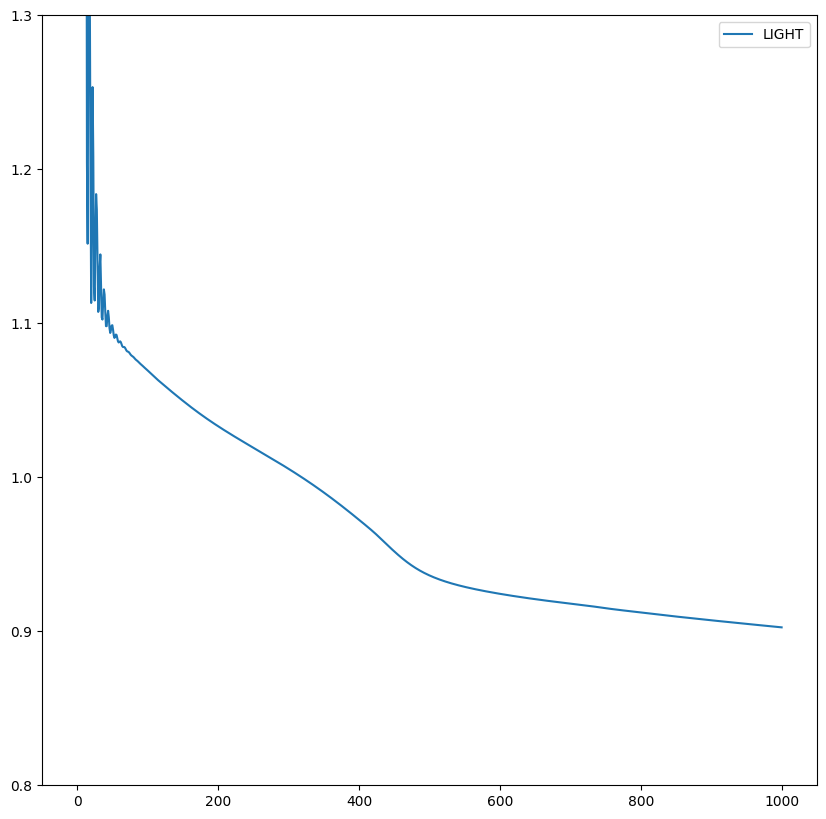

In [23]:
plot_loss(losses_, ylim=1.3, ylim_bottom=0.8)

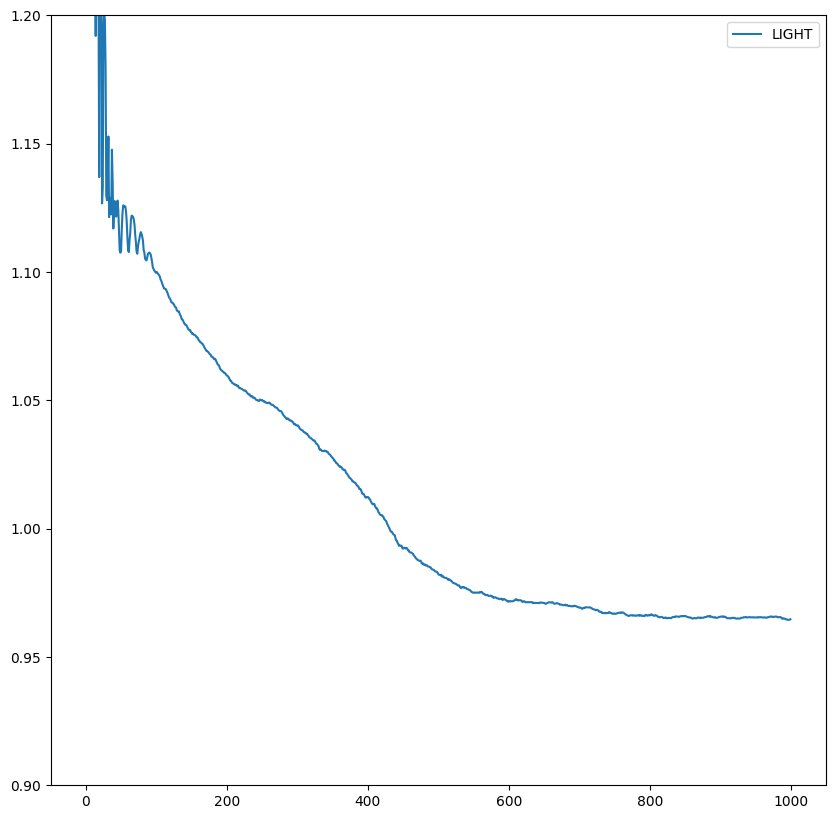

In [26]:
plot_val(losses_, ylim=1.2, ylim_bottom=0.9)